## This file applyes the Pre - trained Resnet50 model on original and Histogram Median Filter

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
result = {}
test_acc_list = []
test_loss_list = []

## Loading and Extracting Original Dataset

In [8]:
import zipfile

zip_path = "/content/drive/MyDrive/UB_Study/CVIP_Project/FERDataset.zip"
extract_to = "/content/FERDataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Dataset unzipped to local Colab storage.")

Dataset unzipped to local Colab storage.


In [ ]:
import os
dir = "/content/FERDataset"
def count_files(directory):
    total_files = 0
    no_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
        no_files += len(files)
        print(root,dirs,no_files)
        no_files=0
    return total_files

print("Total files extracted:", count_files(dir))

/content/FERDataset ['test', 'train'] 0
/content/FERDataset/test ['angry', 'disgust', 'surprise', 'happy', 'fear', 'neutral', 'sad'] 0
/content/FERDataset/test/angry [] 958
/content/FERDataset/test/disgust [] 111
/content/FERDataset/test/surprise [] 831
/content/FERDataset/test/happy [] 1774
/content/FERDataset/test/fear [] 1024
/content/FERDataset/test/neutral [] 1233
/content/FERDataset/test/sad [] 1247
/content/FERDataset/train ['angry', 'disgust', 'surprise', 'happy', 'fear', 'neutral', 'sad'] 0
/content/FERDataset/train/angry [] 3995
/content/FERDataset/train/disgust [] 436
/content/FERDataset/train/surprise [] 3171
/content/FERDataset/train/happy [] 7215
/content/FERDataset/train/fear [] 4097
/content/FERDataset/train/neutral [] 4965
/content/FERDataset/train/sad [] 4830
Total files extracted: 35887


# Defining a Pre -Trained Resenet50 Model

In [22]:
data_dir = '/content/FERDataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
batch_size = 64
num_classes = 7
num_epochs = 15
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


In [23]:
#-----Training-----
for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total:.4f}, Accuracy: {acc:.2f}%")


Epoch [1/15], Loss: 1.8319, Accuracy: 25.10%
Epoch [2/15], Loss: 1.7315, Accuracy: 28.62%
Epoch [3/15], Loss: 1.5759, Accuracy: 37.34%
Epoch [4/15], Loss: 1.4139, Accuracy: 44.96%
Epoch [5/15], Loss: 1.3184, Accuracy: 48.96%
Epoch [6/15], Loss: 1.2531, Accuracy: 51.49%
Epoch [7/15], Loss: 1.2048, Accuracy: 54.02%
Epoch [8/15], Loss: 1.1555, Accuracy: 55.80%
Epoch [9/15], Loss: 1.1108, Accuracy: 57.46%
Epoch [10/15], Loss: 1.0680, Accuracy: 59.57%
Epoch [11/15], Loss: 1.0291, Accuracy: 61.03%
Epoch [12/15], Loss: 0.9863, Accuracy: 63.06%
Epoch [13/15], Loss: 0.9444, Accuracy: 64.27%
Epoch [14/15], Loss: 0.8911, Accuracy: 66.24%
Epoch [15/15], Loss: 0.8371, Accuracy: 68.34%


In [21]:
model.eval()
correct, total, total_test_loss = 0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


test_acc = correct / total * 100
test_loss = total_test_loss / total

print(f"\nTest Accuracy: {test_acc:.2f}%")


Test Accuracy: 58.93%


In [26]:
torch.save(model.state_dict(), 'Resnet50_Original.pth')

## Applying Resnet50 model on Histogram + Median filtered Dataset

In [4]:
import zipfile

zip_path = "/content/drive/MyDrive/UB_Study/CVIP_Project/Preprocessed_Dataset/Histogram_Median.zip"
extract_to = "/content/Histogram_Median"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Dataset unzipped to local Colab storage.")

Dataset unzipped to local Colab storage.


In [5]:
import os
dir = "/content/Histogram_Median/Histogram_Median"
def count_files(directory):
    total_files = 0
    no_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
        no_files += len(files)
        print(root,dirs,no_files)
        no_files=0
    return total_files

print("Total files extracted:", count_files(dir))

/content/Histogram_Median/Histogram_Median ['train', 'test'] 0
/content/Histogram_Median/Histogram_Median/train ['happy', 'angry', 'surprise', 'fear', 'neutral', 'sad', 'disgust'] 0
/content/Histogram_Median/Histogram_Median/train/happy [] 7215
/content/Histogram_Median/Histogram_Median/train/angry [] 3995
/content/Histogram_Median/Histogram_Median/train/surprise [] 3171
/content/Histogram_Median/Histogram_Median/train/fear [] 4097
/content/Histogram_Median/Histogram_Median/train/neutral [] 4965
/content/Histogram_Median/Histogram_Median/train/sad [] 4830
/content/Histogram_Median/Histogram_Median/train/disgust [] 436
/content/Histogram_Median/Histogram_Median/test ['happy', 'angry', 'surprise', 'fear', 'neutral', 'sad', 'disgust'] 0
/content/Histogram_Median/Histogram_Median/test/happy [] 1774
/content/Histogram_Median/Histogram_Median/test/angry [] 958
/content/Histogram_Median/Histogram_Median/test/surprise [] 831
/content/Histogram_Median/Histogram_Median/test/fear [] 1024
/content

In [ ]:
data_dir = '/content/Histogram_Median/Histogram_Median'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
batch_size = 64
num_classes = 7
num_epochs = 15
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# -----Training----------
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total * 100
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

# ----Evaluation---------
model.eval()
correct, total, total_test_loss = 0, 0, 0
loss_plot = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss_plot.append(total_test_loss / total)


test_acc = correct / total * 100
test_loss = total_test_loss / total

test_acc_list.append(test_acc)
test_loss_list.append(test_loss)



print(f"\n Test Accuracy: {test_acc:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Epoch [1/15], Loss: 1.2422, Accuracy: 52.82%
Epoch [2/15], Loss: 0.9115, Accuracy: 66.44%
Epoch [3/15], Loss: 0.6598, Accuracy: 75.70%
Epoch [4/15], Loss: 0.3914, Accuracy: 86.24%
Epoch [5/15], Loss: 0.2136, Accuracy: 92.81%
Epoch [6/15], Loss: 0.1476, Accuracy: 95.17%
Epoch [7/15], Loss: 0.1224, Accuracy: 96.02%
Epoch [8/15], Loss: 0.1109, Accuracy: 96.29%
Epoch [9/15], Loss: 0.0877, Accuracy: 97.16%
Epoch [10/15], Loss: 0.0957, Accuracy: 96.83%
Epoch [11/15], Loss: 0.0914, Accuracy: 96.99%
Epoch [12/15], Loss: 0.0727, Accuracy: 97.54%
Epoch [13/15], Loss: 0.0817, Accuracy: 97.28%
Epoch [14/15], Loss: 0.0754, Accuracy: 97.49%
Epoch [15/15], Loss: 0.0593, Accuracy: 98.07%

 Test Accuracy: 60.17%


#### The Resnet50 Model gave the accuracy of 60.17%

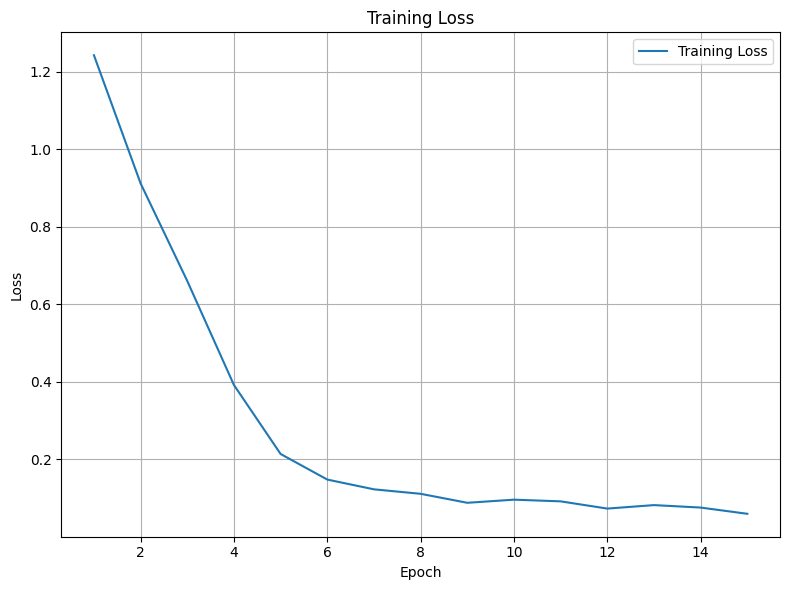

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()